**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [76]:
import numpy as np
import pandas as pd
import datetime as dt
import math
import ipywidgets as widgets
from types import SimpleNamespace
from copy import copy
from scipy import optimize
from scipy.optimize import minimize
import sympy as sm
from IPython.display import display
from sympy import * 
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [77]:
# Define parameters and variables with sympy
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
alpha = sm.symbols('alpha')
kappa = sm.symbols('kappa')
nu = sm.symbols('nu')
w = sm.symbols('w')
wtilde = sm.symbols("wtilde")
tau = sm.symbols('tau')
C = sm.symbols('C')
G = sm.symbols('G')
L = sm.symbols('L')

We solve this problem with Sympy in four steps and some algebra. First, we define our utility function and constraint. Second, we insert insert the constraint into the utility function. Next, we take the derivative of utility w.r.t. $L$. And the last step is to solve for $L^*$. Finally, we use simple algebra to reduce the expression further, which yields the desired result.

In [78]:
# Define objective
objective = sm.log(C**alpha*G**(1-alpha))-nu*L**2/2
objective

-L**2*nu/2 + log(C**alpha*G**(1 - alpha))

In [79]:
# Define constraint
constraint = sm.Eq(kappa+wtilde*L, C)
constraint

Eq(L*wtilde + kappa, C)

In [80]:
# Define constraint as C
C_from_con = sm.solve(constraint, C)
C_from_con[0]

L*wtilde + kappa

In [81]:
# Insert expresstion into objective
objective_subs = objective.subs(C, C_from_con[0])
objective_subs

-L**2*nu/2 + log(G**(1 - alpha)*(L*wtilde + kappa)**alpha)

In [82]:
# Take derivative w.r.t. L
foc = sm.diff(objective_subs, L)
foc

G**(1 - alpha)*G**(alpha - 1)*alpha*wtilde/(L*wtilde + kappa) - L*nu

In [83]:
# Solve for L^*
sol = sm.solve(sm.Eq(foc,0), L)
sol[1] #printing the positive result of the quadratic equation

(-kappa*nu + sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(2*nu*wtilde)

In [84]:
# Print solution in latex-format to continue calculations
print(sm.latex(sol[1]))

\frac{- \kappa \nu + \sqrt{\nu \left(4 \alpha \tilde{w}^{2} + \kappa^{2} \nu\right)}}{2 \nu \tilde{w}}


From the solution, we can now rearrange in order to obtain the specified function: 
\begin{align*}
L^*(\tilde{w})&=\frac{- \kappa \nu + \sqrt{\nu \left(4 \alpha \tilde{w}^{2} + \kappa^{2} \nu\right)}}{2 \nu \tilde{w}}\\
&= \frac{- \kappa \nu + \sqrt{\nu^2 \left(4 \frac{\alpha}{\nu} \tilde{w}^{2} + \kappa^{2} \right)}}{2 \nu \tilde{w}}\\
&= \frac{- \kappa \nu + \nu \sqrt{\kappa^{2} + 4 \frac{\alpha}{\nu} \tilde{w}^{2} }}{2 \nu \tilde{w}}\\
&= \frac{\nu\left(- \kappa + \sqrt{\kappa^{2} + 4 \frac{\alpha}{\nu} \tilde{w}^{2} }\right)}{2 \nu \tilde{w}}\\
&= \frac{- \kappa + \sqrt{\kappa^{2} + 4 \frac{\alpha}{\nu} \tilde{w}^{2} }}{2 \tilde{w}}
\end{align*}

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

With the expression of $L^*(\tilde{w})$, we can now illustrate how the optimal amount of labor hours responds to changes in the real wage level. 

<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in divide
  return (1/2)*(-kappa*nu + sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(nu*wtilde)


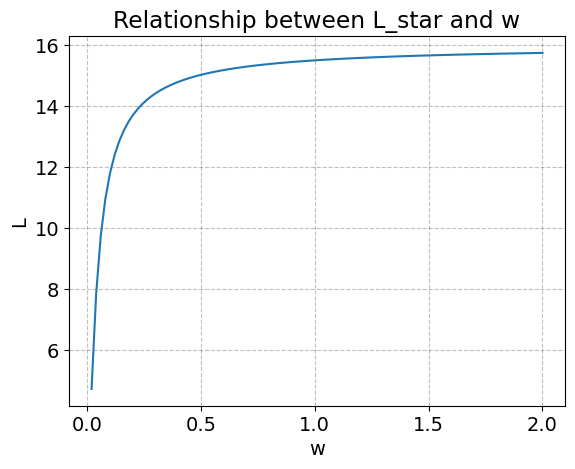

In [85]:
# Define solution function as L^* above
sol_func = sm.lambdify(args=(alpha, kappa, nu, wtilde), expr=sol[1])

# Set parameter values and vector
alpha_val = 0.5
kappa_val = 1.0
nu_val = 1 / (2 * 16 ** 2)
wtilde_val = (1-tau)*w
w_vec = np.linspace(0,2,100)

# Derive L-values as a function of wtilde
L_star = sol_func(alpha_val, kappa_val, nu_val, w_vec)

# Plot results
plt.plot(w_vec, L_star)
plt.xlabel('w')
plt.ylabel('L')
plt.title('Relationship between L_star and w')
plt.show()

The plot shows a relationship between $L^*$ and real wages, which is naturally positive, since you are willing to work more hours if wages are higher in order to maximize utility through consumption and government spendings. However, the positive effect itself is decreasing in $w$, and the value of $L$ converges to around 16, when $w\rightarrow\infty$.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


We define the hours of labor ($L$), the size of government consumption ($G$) and worker utility ($"U"$) one by one. First, we define the optimal amount of labor hours as a function of $\tau$. We do that by creating a vector of $\tau$ values from 0 to 1 with spaces of 0.025 and looping over these values and calculate a value of $L$ for each one.

We use these values of $L$ in order to find $G$ values for the same values of $\tau$. We then use both the derived $L$ and $G$ values and loop over the $\tau$ vector to find how the worker utility responds to changes in the tax rate. 

Finally, we insert the derivations into separate figures.

In [86]:
# Define optimal L
def L_func(alpha, kappa, nu, tau, w):
    return (-kappa+sqrt(kappa**2+4*(alpha/nu)*(w*(1-tau))**2))/2*w*(1-tau)

# Set parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16 ** 2)
w = 1.0

# Define vector of tau values
tau_vec = np.linspace(0,1,41)

# Create empty L-vector
L_vec = np.empty(41)

# Loop over tau values and find corresponding L values
for i, tau in enumerate(tau_vec):
    L_vec[i] = L_func(alpha, kappa, nu, tau, w)

In [87]:
# Define government consumption
def G_func(tau, L_star, w):
    return tau*w*L_vec[i]*((1-tau)*w) 

# Create empty G-vector
G_vec = np.empty(41)

# Loop over tau values and find corresponding G values (given L values)
for i, tau in enumerate(tau_vec):
    G_vec[i] = G_func(tau, L_star, w)

In [88]:
# Define utility
def U_func(kappa, tau, L_star, G, alpha, nu):
    arg = kappa + w * (1 - tau) * L_star
    if arg > 0 and G > 0:
        return math.log(arg**alpha * G**(1 - alpha)) - nu * L_star**2 / 2
    else:
        return float('-inf')  # Return negative infinity if the argument is non-positive

# Create empty U-vector
U_vec = np.empty(41)

# Loop over tau values and find corresponding U values (given L and G values)
for i, tau in enumerate(tau_vec):
    U_vec[i] = U_func(kappa, tau, L_vec[i], G_vec[i], alpha, nu)

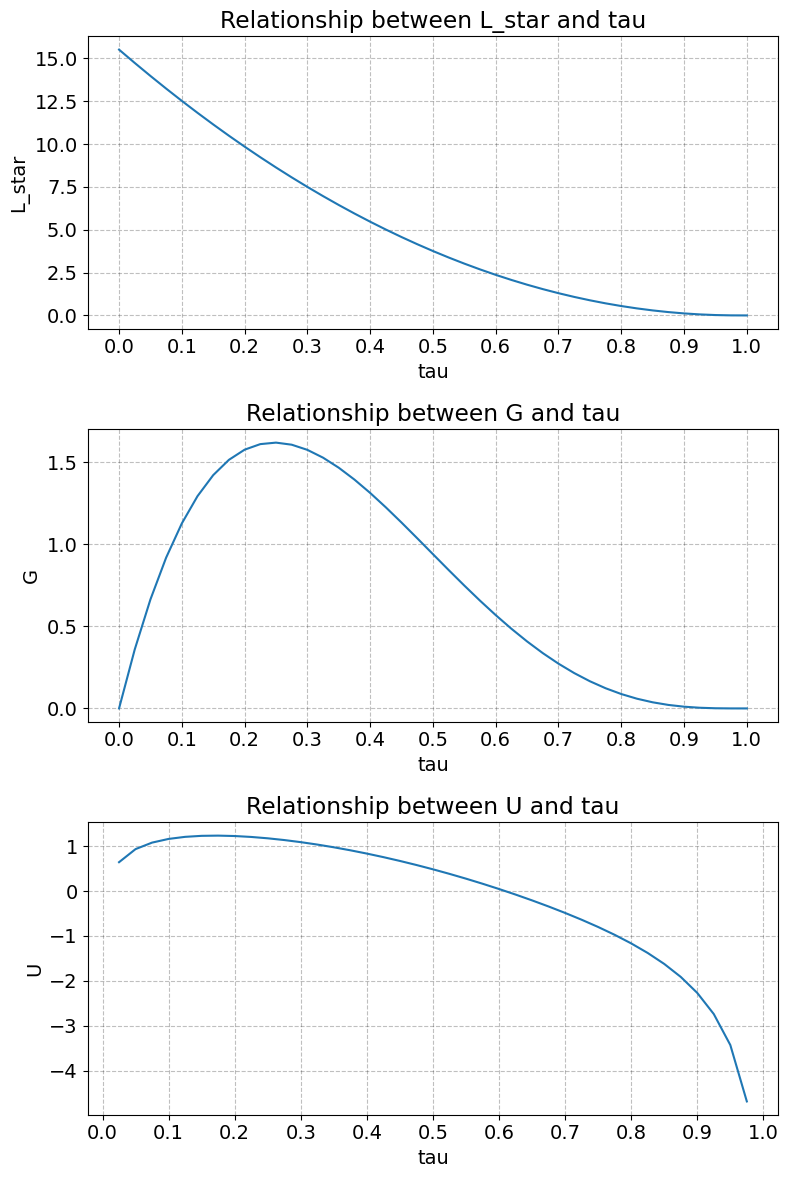

In [89]:
# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot 1: Relationship between L_star and tau
axs[0].plot(tau_vec, L_vec)
axs[0].set_xlabel('tau')
axs[0].set_ylabel('L_star')
axs[0].set_title('Relationship between L_star and tau')
axs[0].set_xticks(np.arange(0, 1.1, 0.1))

# Plot 2: Relationship between G and tau
axs[1].plot(tau_vec, G_vec)
axs[1].set_xlabel('tau')
axs[1].set_ylabel('G')
axs[1].set_title('Relationship between G and tau')
axs[1].set_xticks(np.arange(0, 1.1, 0.1))

# Plot 3: Relationship between U and tau
axs[2].plot(tau_vec, U_vec)
axs[2].set_xlabel('tau')
axs[2].set_ylabel('U')
axs[2].set_title('Relationship between U and tau')
axs[2].set_xticks(np.arange(0, 1.1, 0.1))

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure with all subplots
plt.show()

The first plot shows a negative relationship between hours of labor and the tax rate. This is because the effective wage decreases in $\tau$ and the incentive to work becomes smaller. The numerical slope of the curve decreases as the tax rate increases, suggesting that work is important if you want to be able to consume and maximize utility.

The second plot shows how much the government is able to consume for different tax rates. In the beginning it's increasing as more tax they generate more tax revenue, but at some point ($\tau\approx0.25$) it starts to decrease as the willingness to work falls and ultimately reduces the revenue. The relationship is a typical result in economics, usually reffered to as the "Laffer curve".

The third plot shows that utility is maximized when the tax rate is lower than the one, which maximizes goverment consumption. The overall relationship resembling an inverted U shape is however the same a before, but the disutility significantly increases when tax rates are sufficiently high.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

We can simply define the socially optimal tax rate by reffering to the $\tau$ value, that can maximize utility. We then print the result.

In [90]:
# Define the socially optimal tau
optimal_tau = tau_vec[np.argmax(U_vec)]

print('The socially optimal tax rate, tau^*, is:', optimal_tau)

The socially optimal tax rate, tau^*, is: 0.17500000000000002


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [91]:
# Define additional parameters
L = sm.Symbol('L')
w = sm.Symbol('w')
tau = sm.Symbol('tau')
G = sm.Symbol('G')
alpha = sm.Symbol('alpha')
sigma = sm.Symbol('sigma')
rho = sm.Symbol('rho')
epsilon = sm.Symbol('epsilon')
kappa = sm.Symbol('kappa')
nu = sm.Symbol('nu')

In [92]:
objective_gen = (((alpha * C**((sigma-1)/sigma) + (1 - alpha) * G**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1-rho) - 1) / (1 - rho) - nu * (L**(1 + epsilon)) / (1 + epsilon)
objective_gen

-L**(epsilon + 1)*nu/(epsilon + 1) + (((C**((sigma - 1)/sigma)*alpha + G**((sigma - 1)/sigma)*(1 - alpha))**(sigma/(sigma - 1)))**(1 - rho) - 1)/(1 - rho)

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [93]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In order to show numerically that the statement above maximizes profit for $\kappa \in \{1.0,2.0\}$, we are calculating the optimal profit and optimal $\ell_t$ for both values for $\kappa$.

In [94]:
# calculate profits
def calculate_profits(kappa, eta, w, ell):
    price = kappa * ell**(-eta)
    profits = price * ell - w * ell
    return profits

# Define the parameters
eta = 0.5
w = 1.0
kappas = [1.0, 2.0]

for kappa in kappas:
    best_ell = ((1 - eta) * kappa / w) ** (1 / eta)
    max_profits = calculate_profits(kappa, eta, w, best_ell)
    
    # Compare profits for different ell values
    ell_values = np.linspace(0.01, 5.0, num=100)
    profit_values = []
    for ell in ell_values:
        profits = calculate_profits(kappa, eta, w, ell)
        profit_values.append(profits)
    
    # Find the ell value that maximizes profits
    optimal_ell = ell_values[np.argmax(profit_values)]
    max_profits_numeric = np.max(profit_values)
    
    # Print the results
    print(f"For kappa = {kappa}:")
    print(f"Analytical optimal ell: {best_ell:.2f}, Maximized profits: {max_profits:.2f}")
    print(f"Numerical optimal ell: {optimal_ell:.2f}, Maximized profits (numeric): {max_profits_numeric:.2f}")
    print()

For kappa = 1.0:
Analytical optimal ell: 0.25, Maximized profits: 0.25
Numerical optimal ell: 0.26, Maximized profits (numeric): 0.25

For kappa = 2.0:
Analytical optimal ell: 1.00, Maximized profits: 1.00
Numerical optimal ell: 1.02, Maximized profits (numeric): 1.00



kommenter på resultatet

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [95]:
# set the parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1 + 0.01) ** (1 / 12)
T = 120
K = 2000
seed_value = 1

# set random seed
np.random.seed(seed_value)

# define the policy function (defined for question 3, but introducing it now for consistency)
def policy_function(kappa, eta, w, delta):
    return ((1 - eta) * kappa / w) ** (1 / eta) if abs(kappa - w) > delta else kappa

# calculate H based on the policy with delta=0
def calculate_H_with_policy(delta):
    # initialize variables
    kappa = 1.0
    employment = 0
    H = 0
    # simulate shock series
    shock_series = [np.log(kappa)]

    for t in range(120):
        # generate shock
        epsilon = np.random.normal(-0.5 * sigma_epsilon**2, sigma_epsilon)
        shock = rho * shock_series[t] + epsilon
        shock_series.append(shock)

        # calculate policy employment level
        employment_policy = policy_function(np.exp(shock), eta, w, delta)

        # update employment level
        employment = employment_policy if abs(employment - employment_policy) > delta else employment

        # calculate profits
        price = np.exp(shock) * employment ** (-eta)
        profits = price * employment - w * employment

        # add profits to H
        H += R ** (-t) * (profits - int(abs(employment - employment_policy) > delta) * iota)

    return H

# calculate H using the given policy and fixed Delta
H_values = []

# repeat the calculation multiple times to get a consistent result
num_iterations = 3500
for _ in range(num_iterations):
    H = calculate_H_with_policy(delta=0)
    H_values.append(H)

# take the average of the calculated H values
average_H = np.mean(H_values)

print("Average H:", round(average_H, 2))

Average H: 28.91


We have chosen to put $K=2000$, as this is suitable for obtaining a correct result. By doing so, we get a value of $H=28.91$

### Ny opgave

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [96]:
#set seed
np.random.seed(seed_value)

# calculate H using the given policy and fixed delta=0.05
fixed_delta = 0.05
H_fixed_delta_values = []

# repeat the calculation multiple times in order to get precise results
num_iterations = 3500
for _ in range(num_iterations):
    H_fixed_delta = calculate_H_with_policy(delta=fixed_delta)
    H_fixed_delta_values.append(H_fixed_delta)

# take the average of the calculated H values
average_H_fixed_delta = np.mean(H_fixed_delta_values)

print("Average H with delta = 0.05:", round(average_H_fixed_delta, 2))

Average H with delta = 0.05: 23.89


We now get a value of $H=23.89$, using the same number of shock series $K=2000$. We can see, that including $\Delta=0.05$ decreses the profitability, as H is now $23.89$ instead of $28.91$ as we found in Q2. There is thus no improvement of profitability when including the new policy.

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

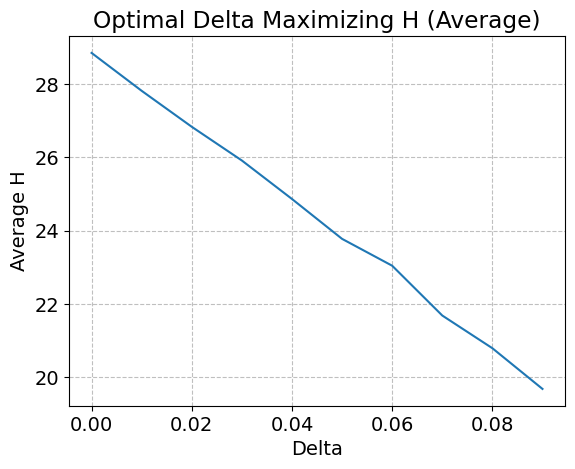

Optimal Delta: 0.0
Maximized H: 28.85


In [97]:
# making list of delta values and H values
delta_values = np.arange(0, 0.1, 0.01)
H_values = []

# repeat the optimization process multiple times to get consistent results
num_iterations = 1000
for _ in range(num_iterations):
    H_values_iter = []
    for delta in delta_values:
        H = calculate_H_with_policy(delta)
        H_values_iter.append(H)
    H_values.append(H_values_iter)

# take the average of the calculated H values for each delta
average_H_values = np.mean(H_values, axis=0)

# find the optimal Delta maximizing H
optimal_delta_index = np.argmax(average_H_values)
optimal_delta = delta_values[optimal_delta_index]
max_H = average_H_values[optimal_delta_index]

# plot the relationship between Delta and average H
plt.plot(delta_values, average_H_values)
plt.xlabel("Delta")
plt.ylabel("Average H")
plt.title("Optimal Delta Maximizing H (Average)")
plt.grid(True)
plt.show()

print("Optimal Delta:", round(optimal_delta, 2))
print("Maximized H:", round(max_H, 2))

In this case, we can see that H is actually optimized when $\Delta=0.0$. In this case we have that $H=28.93$. We can see from the plot than the larger the value of $\Delta$ gets, the more the profitability decreases. We can thus conclude that the new policy, does not make profitability. 


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In order to improve profitability

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [98]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

Iteration 0: x_k0 = [ 184.30750256 -461.99166825], f(x_k0) = 63.351443091130655
Iteration 1: x_k0 = [540.33943722 -21.37031829], f(x_k0) = 74.93286352602217
Iteration 2: x_k0 = [ 446.96944222 -345.20078289], f(x_k0) = 80.35847231181837
Iteration 3: x_k0 = [-551.14845028 -123.36664639], f(x_k0) = 80.89464339099932
Iteration 4: x_k0 = [-320.24136318  410.0888691 ], f(x_k0) = 68.1119672669253
Iteration 5: x_k0 = [-351.50118674  290.9634403 ], f(x_k0) = 53.08326802401512
Iteration 6: x_k0 = [-129.41504663 -381.29217606], f(x_k0) = 42.226396120276426
Iteration 7: x_k0 = [ 292.24729751 -516.50150284], f(x_k0) = 89.74226064144602
Iteration 8: x_k0 = [462.40464526 543.17327907], f(x_k0) = 128.7882266762382
Iteration 9: x_k0 = [ 517.37212161 -101.48285635], f(x_k0) = 70.0114611766188
Final Iteration 355: x_k0 = [-0.50236784  2.24510885], f(x_k0) = 1.015990159963217
Global Minimum:
f(x) =  0.0
x =  [-9.40178005e-09  3.26340922e-09]


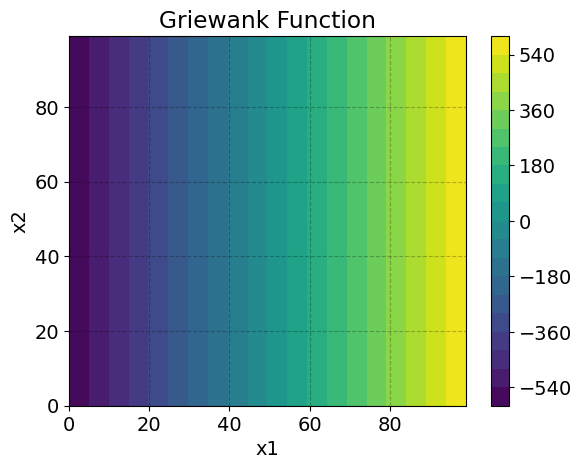

In [99]:
def refined_global_optimizer(bounds, tau, K_warmup, K_max):
    x_ast = None

    for k in range(K_max):
        x_k = np.random.uniform(bounds[0], bounds[1], size=2)

        if k >= K_warmup:
            chi_k = 0.50 * 2 / (1 + np.exp((k - K_warmup) / 100))
            x_k0 = chi_k * x_k + (1 - chi_k) * x_ast
        else:
            x_k0 = x_k

        result = minimize(griewank, x_k0, method='BFGS', tol=tau)
        x_k_ast = result.x

        if x_ast is None or griewank(x_k_ast) < griewank(x_ast):
            x_ast = x_k_ast

        if griewank(x_ast) < tau:
            break

        if k < 10:  # Display the first 10 iterations
            print(f"Iteration {k}: x_k0 = {x_k0}, f(x_k0) = {griewank(x_k0)}")

    # Display the final iteration where the global minimum is reached
    print(f"Final Iteration {k}: x_k0 = {x_k0}, f(x_k0) = {griewank(x_k0)}")

    return x_ast

# Set the settings
np.random.seed(1000)
bounds = [-600, 600]
tau = 1e-8
K_warmup = 10
K_max = 1000

# Run the optimizer
global_optimum = refined_global_optimizer(bounds, tau, K_warmup, K_max)

print("Global Minimum:")
print("f(x) = ", griewank(global_optimum))
print("x = ", global_optimum)

# Create grid for the plot
x1 = np.linspace(bounds[0], bounds[1], 100)
x2 = np.linspace(bounds[0], bounds[1], 100)
X1, X2 = np.meshgrid(x1, x2)
Z = griewank_(X1, X2)

# Plot the graph
plt.contourf(X1, X2, levels=20)
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Griewank Function')
plt.show()



**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

Iteration 0: x_k0 = [ 184.30750256 -461.99166825], f(x_k0) = 63.351443091130655
Iteration 1: x_k0 = [540.33943722 -21.37031829], f(x_k0) = 74.93286352602217
Iteration 2: x_k0 = [ 446.96944222 -345.20078289], f(x_k0) = 80.35847231181837
Iteration 3: x_k0 = [-551.14845028 -123.36664639], f(x_k0) = 80.89464339099932
Iteration 4: x_k0 = [-320.24136318  410.0888691 ], f(x_k0) = 68.1119672669253
Iteration 5: x_k0 = [-351.50118674  290.9634403 ], f(x_k0) = 53.08326802401512
Iteration 6: x_k0 = [-129.41504663 -381.29217606], f(x_k0) = 42.226396120276426
Iteration 7: x_k0 = [ 292.24729751 -516.50150284], f(x_k0) = 89.74226064144602
Iteration 8: x_k0 = [462.40464526 543.17327907], f(x_k0) = 128.7882266762382
Iteration 9: x_k0 = [ 517.37212161 -101.48285635], f(x_k0) = 70.0114611766188
Final Iteration 99: x_k0 = [ 158.97167073 -143.52755421], f(x_k0) = 12.649552414689289
Global Minimum:
f(x_ast) = 0.03945868819541687
x_ast = [-1.25600905e+01  2.09409697e-09]


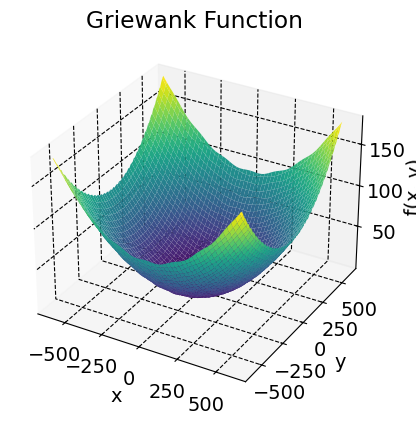

In [100]:
def refined_global_optimizer(bounds, tau, K_warmup, K_max):
    x_ast = None

    for k in range(K_max):
        x_k = np.random.uniform(bounds[0], bounds[1], size=2)

        if k >= K_warmup:
            chi_k = 0.50 * 2 / (1 + np.exp((k - K_warmup) / 100))
            x_k0 = chi_k * x_k + (1 - chi_k) * x_ast
        else:
            x_k0 = x_k

        result = minimize(griewank, x_k0, method='BFGS', tol=tau)
        x_k_ast = result.x

        if x_ast is None or griewank(x_k_ast) < griewank(x_ast):
            x_ast = x_k_ast

        if griewank(x_ast) < tau:
            break

        if k < 10:  # Display the first 10 iterations
            print(f"Iteration {k}: x_k0 = {x_k0}, f(x_k0) = {griewank(x_k0)}")

    # Display the final iteration where the global minimum is reached
    print(f"Final Iteration {k}: x_k0 = {x_k0}, f(x_k0) = {griewank(x_k0)}")

    return x_ast

# Set the settings
np.random.seed(1000)
bounds = [-600, 600]
tau = 1e-8
K_warmup = 10
K_max = 100  # Set K_max to 100

# Run the optimizer
global_optimum = refined_global_optimizer(bounds, tau, K_warmup, K_max)

print("Global Minimum:")
print("f(x_ast) =", griewank(global_optimum))
print("x_ast =", global_optimum)

# Create meshgrid for 3D plot
x = np.linspace(bounds[0], bounds[1], 100)
y = np.linspace(bounds[0], bounds[1], 100)
X, Y = np.meshgrid(x, y)
Z = griewank([X, Y])

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Griewank Function')
plt.show()